In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 100行"深度学习"框架

Credit：[karpathy/micrograd](https://github.com/karpathy/micrograd)

In [3]:
def unbroadcast(out, shape):
    sum_axis = [i for i in range(len(shape)) if shape[i]==1 and out.shape[i] > 1]
    return out.sum(axis=tuple(sum_axis)).reshape(shape)

class Tensor(object):
    def __init__(self, data, children=(), op="", grad_required=True, name=""):
        # 数据(self.data)、梯度(self.grad)以及梯度计算方法(self._backward)
        self.data = data
        self.grad_required = grad_required
        self.grad = np.zeros_like(data) if grad_required else None
        self._backward = lambda: None
        self._prev = set(children)
        self._op = op
        self._name = name

    def zero_grad(self):
        if self.grad_required:
            self.grad = np.zeros_like(self.data)

    def backward(self):
        # 拓扑排序，确定链式法则的应用顺序
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # 应用链式法则计算每个Tensor的梯度
        self.grad = np.ones_like(self.data)
        for v in reversed(topo):
            v._backward()

    # 算子（operators）
    def mean(self):
        out = Tensor(self.data.mean(), (self, ), 'mean') # 算子的正向计算过程

        def _backward():
            # 定义算子的梯度计算方法
            if self.grad_required:
                self.grad += out.grad * np.ones_like(self.grad) / self.grad.data.shape[0]
        out._backward = _backward

        return out

    def matmul(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other, grad_required=False)
        out = Tensor(self.data @ other.data, (self, other), 'matmul')

        def _backward():
            if self.grad_required:
                self.grad += out.grad @ other.data.T
            if other.grad_required:
                other.grad += self.data.T @ out.grad
        out._backward = _backward

        return out

    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other, grad_required=False)
        out = Tensor(self.data + other.data, (self, other), '+')

        def _backward():
            if self.grad_required:
                self.grad += unbroadcast(out.grad, self.grad.shape)
            if other.grad_required:
                other.grad += unbroadcast(out.grad, other.grad.shape)
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other, grad_required=False)
        out = Tensor(self.data * other.data, (self, other), '*')

        def _backward():
            if self.grad_required:
                self.grad += unbroadcast(other.data * out.grad, self.grad.shape)
            if other.grad_required:
                other.grad += unbroadcast(self.data * out.grad, other.grad.shape)
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Tensor(self.data**other, (self,), f'**{other}')

        def _backward():
            if self.grad_required:
                self.grad += unbroadcast((other * self.data**(other-1)) * out.grad, self.grad.shape)
        out._backward = _backward

        return out

    def relu(self):
        out = Tensor(np.maximum(self.data, 0), (self,), 'relu')

        def _backward():
            if self.grad_required:
                self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Tensor(data={self.data}, grad={self.grad}, shape={self.data.shape})"

# 框架应用

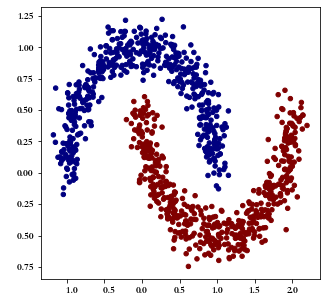

In [13]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [14]:
class Model(object):
    def __init__(self):
        # 定义网络参数
        self.w1 = Tensor(np.random.uniform(-1,1,(2,16)), name="w1")
        self.b1 = Tensor(np.random.uniform(-1,1,(1,16)), name="b1")
        self.w2 = Tensor(np.random.uniform(-1,1,(16,16)), name="w2")
        self.b2 = Tensor(np.random.uniform(-1,1,(1,16)), name="b2")
        self.w3 = Tensor(np.random.uniform(-1,1,(16,1)), name="w3")
        self.b3 = Tensor(np.random.uniform(-1,1,(1,1)), name="b3")
        self.params = [self.w1, self.b1, self.w2, self.b2, self.w3, self.b3]
    def forward(self, x):
        # 定义网络结构（三层FeedForward网络）
        t = Tensor(x.reshape(-1,2), grad_required=False)
        h1 = t.matmul(self.w1) + self.b1
        h1 = h1.relu()
        h2 = h1.matmul(self.w2) + self.b2
        h2 = h2.relu()
        out = h2.matmul(self.w3) + self.b3
        return out
    def zero_grad(self):
        for param in self.params:
            param.zero_grad()
            
def train(model, X, y, epochs, learning_rate):
    for i in range(epochs):
        # 前向计算
        p = m.forward(X)
        loss = (1-p*y.reshape(-1,1)).relu()
        loss = loss.mean()
        m.zero_grad()
        # 梯度计算
        loss.backward()
        # 参数优化（Gradient descent method）
        for param in m.params:
            param.data -= param.grad*learning_rate
        print(f"epoch = {i}, loss = {loss.data}")

In [15]:
m = Model()
train(m, X, y, epochs=100, learning_rate=0.5)

epoch = 0, loss = 2.6577436885869434
epoch = 1, loss = 1.7381614374996255
epoch = 2, loss = 0.9630093920904726
epoch = 3, loss = 0.45549374711540136
epoch = 4, loss = 0.33289497414943003
epoch = 5, loss = 0.2674959001568996
epoch = 6, loss = 0.22532695888842022
epoch = 7, loss = 0.2071096290202884
epoch = 8, loss = 0.20296465248309592
epoch = 9, loss = 0.20862241174777232
epoch = 10, loss = 0.24709481801117555
epoch = 11, loss = 0.2794869554496824
epoch = 12, loss = 0.3818095379299991
epoch = 13, loss = 0.25943833332655
epoch = 14, loss = 0.18692025937949752
epoch = 15, loss = 0.16349638824227658
epoch = 16, loss = 0.1539996263234258
epoch = 17, loss = 0.14602479008246633
epoch = 18, loss = 0.1380907629126337
epoch = 19, loss = 0.1301294149889916
epoch = 20, loss = 0.12224145677937247
epoch = 21, loss = 0.11433942818025462
epoch = 22, loss = 0.10632784588866272
epoch = 23, loss = 0.09853690798120358
epoch = 24, loss = 0.09111402551023909
epoch = 25, loss = 0.08443771757782803
epoch = 2

(-1.7455584977329321, 2.004441502267068)

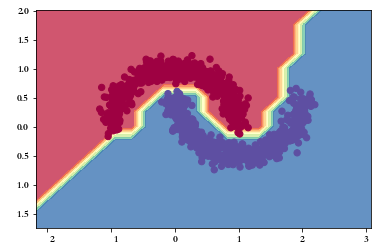

In [16]:
# 决策边界可视化

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
scores = [m.forward(i) for i in Xmesh]
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# 神经网路图分析

In [8]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        label = f"Tensor({n._name},shape={n.data.shape})" if n._name else f"Tensor(shape={n.data.shape})"
        dot.node(name=str(id(n)), label=label, shape="record")
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [9]:
z = m.forward(X[0])

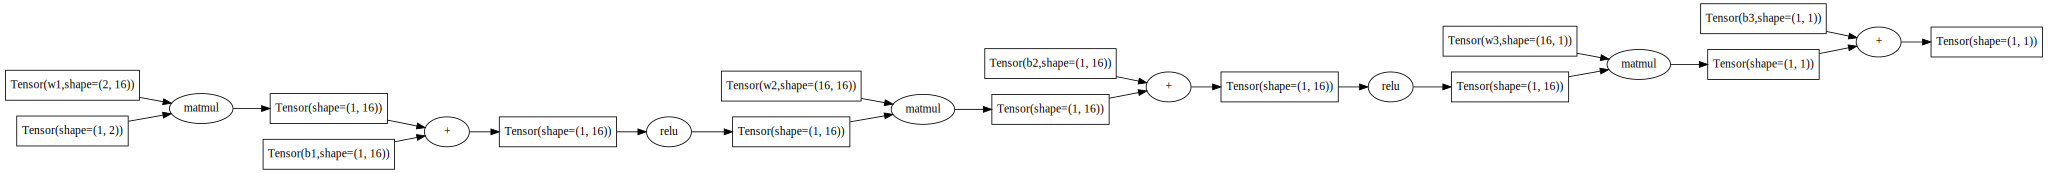

In [11]:
draw_dot(z, rankdir="LR")